# Investment strategies: cross-sectional vs. time-series

#### Author: Gustavo Soares

## Introduction

We will follow [Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://ssrn.com/abstract=2695101) and try to make clear the distinction between two very different implementations of an investment idea: time-series vs. cross-sectional strategies. A cross-sectional strategy is market (or beta) neutral while a time-series strategy is directional. A time-series strategy may also claim to be market neutral because it will be sometimes bullish or sometimes bearish a market, having no bias towards one direction or the other. However, while a cross-sectional strategy is market neutral all the time, a time-series strategy will typically be positioned long or short the market at any point in time.

Let's take the example of [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) where the authors focus on momentum in monthly returns to make the distintion between the two styles of investment strategies clear. We will pull data for 93 different markets and try to see how momentum can be used in both a time-series as well as a cross-sectional format. These are futures markets where we constructed the "tracker" data by rolling futures over time and calculating the pnl in USD. So, the data is really ready to go. Let's import what we are going to need and grab the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
futures = pd.read_csv('futures.csv', index_col=0)
futures.index = pd.to_datetime(futures.index)

## Momentum signals

We will calculate momentum signals in a simple way. Our momentum signal will be simply the difference between the log of today's price vs. the log of the price of a year ago:

In [29]:
mom_signals = np.log(futures).diff(252).shift(1).dropna(how='all')
positions = mom_signals.apply(np.sign)
vols = (np.log(futures).diff(1).ewm(halflife=60).std()*np.sqrt(252)).shift(1)
price_change = futures.diff(1)
mom_ranks = mom_signals.rank(axis=1)

Note the ```.shift(1)``` in the line above to avoid using a signal on date $t$ that was calculated with the closing price on date $t$. If we did that, we traded on date $t$ based on the signal calculated without the ```.shift(1)```, we would be making a decision to be bullish or bearish a market at the openning of the trading date $t$ with information that will only become available at the end of of the trading date $t$. So, we have to use ```.shift(1)```. It is good practice, to test how robust your strategy is for lags that are even larger. Does your strategy work with, say, ```.shift(5)```?

## Time-series implementation

Let's follow the implementation of the time-series momentum strategy as outlined in [Moskowitz, Ooi, and Pedersen (2012)](https://doi.org/10.1016/j.jfineco.2011.11.003) but with weekly rebalancing:

In [16]:
# initial set up
backtest = pd.Series(index=mom_signals.index, dtype=float)
backtest.iloc[0] = 100 # initialize the backtest with 100
start_date = mom_signals.index[0]

# first trade
prices = futures.loc[start_date]
weights = (0.4 / vols.loc[start_date]) * positions.loc[start_date]
holdings = (backtest.iloc[0] * weights / prices).fillna(0)

# loop over the next days
for i in range(1, backtest.shape[0]):
    tdy = backtest.index[i]
    yst = backtest.index[i-1]
    
    # calculate pnl on the day
    pnl = (holdings*price_change.loc[tdy]).mean()
    backtest.iloc[i] = backtest.iloc[i-1] + pnl
    
    if tdy.week != yst.week: # check if it's a new week and reasses trades if so
        prices = futures.loc[tdy]
        weights = (0.4 / vols.loc[tdy]) * positions.loc[tdy]
        holdings = (backtest.iloc[i-1] * weights / prices).fillna(0)
        # Should we have backtest.iloc[i-1] or backtest.iloc[i] above? Why? Think about the trading!

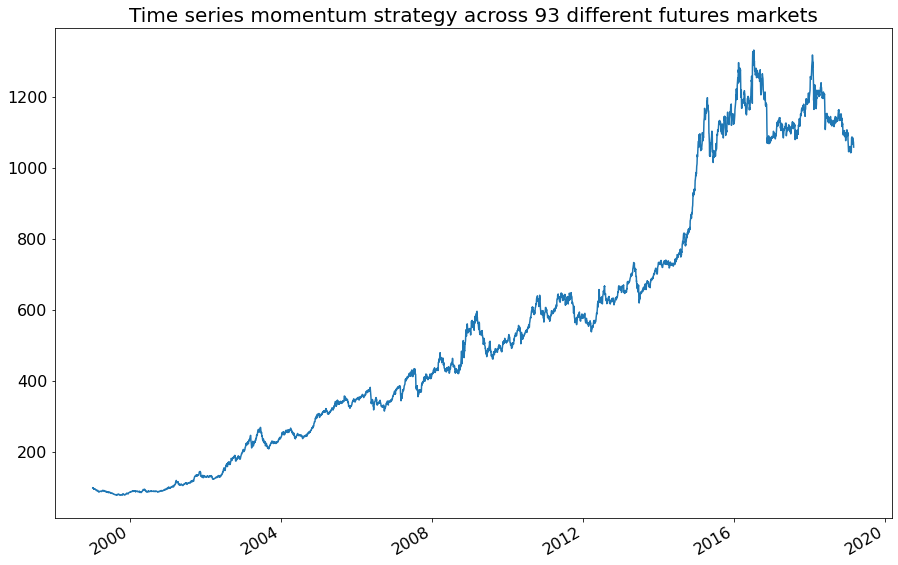

In [19]:
backtest.plot(figsize=(15,10), fontsize=16)
plt.title('Time series momentum strategy across 93 different futures markets', fontsize=20)
plt.show()

## Cross sectional implementation

Let's now follow the implementation of the strategy as outlined in [Asness, Moskowitz, and Pedersen (2012)](https://ssrn.com/abstract=2174501) also with weekly rebalancing:

In [38]:
# initial set up
backtest2 = pd.Series(index=mom_signals.index, dtype=float)
backtest2.iloc[0] = 100 # initialize the backtest with 100
start_date = mom_signals.index[0]

# first trade
prices = futures.loc[start_date]
weights = mom_ranks.loc[start_date] - mom_ranks.loc[start_date].mean()
weights = 2 * weights / weights.abs().sum()
holdings = (backtest2.iloc[0] * weights / prices).fillna(0)

# loop over the next days
for i in range(1, backtest2.shape[0]):
    tdy = backtest2.index[i]
    yst = backtest2.index[i-1]
    
    # calculate pnl on the day
    pnl = (holdings*price_change.loc[tdy]).sum()
    backtest2.iloc[i] = backtest2.iloc[i-1] + pnl
    
    if tdy.week != yst.week: # check if it's a new week and reasses trades if so
        prices = futures.loc[tdy]
        weights = mom_ranks.loc[tdy] - mom_ranks.loc[tdy].mean()
        weights = 2 * weights / weights.abs().sum()
        holdings = (backtest2.iloc[i-1] * weights / prices).fillna(0)
        # Should we have backtest.iloc[i-1] or backtest.iloc[i] above? Why? Think about the trading!

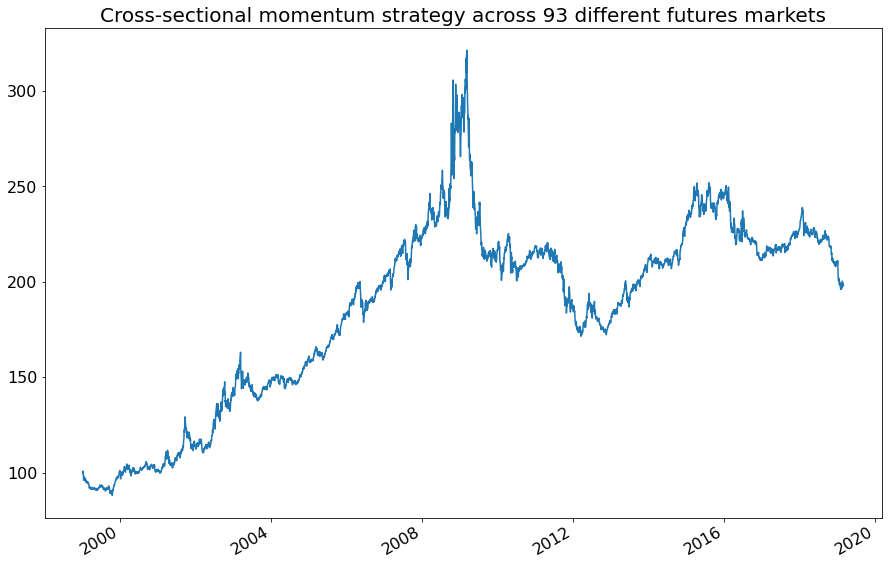

In [39]:
backtest2.plot(figsize=(15,10), fontsize=16)
plt.title('Cross-sectional momentum strategy across 93 different futures markets', fontsize=20)
plt.show()

## Comparison

Let's now compare the two investment strategies that are using exactly the same signals and rebalancing exactly at the same time:

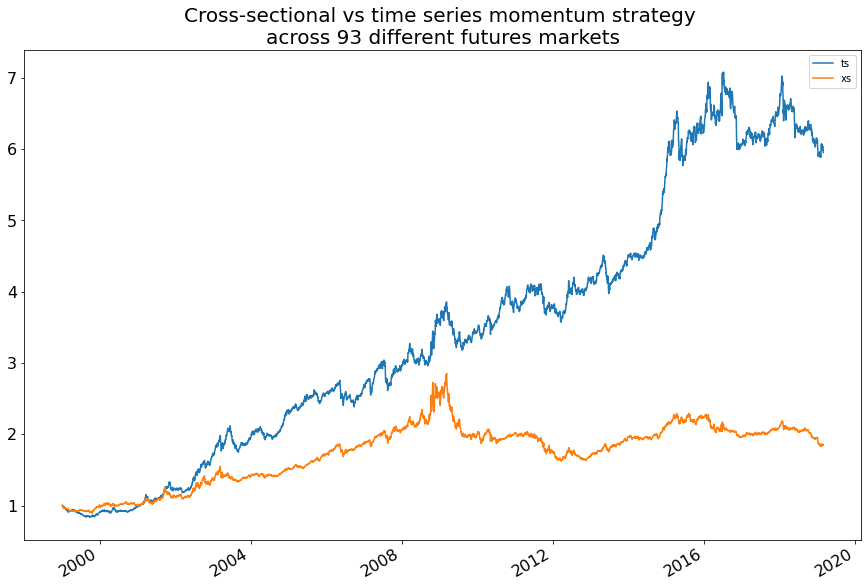

In [42]:
df = pd.concat([backtest.to_frame('ts'), backtest2.to_frame('xs')], axis=1, sort=True)
log_returns = np.log(df).diff(1)
log_returns = (0.1/(log_returns.std() * np.sqrt(252))) * log_returns
df = np.exp(log_returns.fillna(0).cumsum())
df.plot(figsize=(15,10), fontsize=16)
plt.title('Cross-sectional vs time series momentum strategy \nacross 93 different futures markets', fontsize=20)
plt.show()

In [45]:
df.pct_change(1).corr()

,ts,xs
ts,1.000000,0.762961
xs,0.762961,1.000000


## Let's combine the two styles

Let's now combine the two investment strategies:

In [46]:
# initial set up
backtest3 = pd.Series(index=mom_signals.index, dtype=float)
backtest3.iloc[0] = 100 # initialize the backtest with 100
start_date = mom_signals.index[0]

# first trade
prices = df.loc[start_date]
weights = pd.Series(index=['ts', 'xs'], data=[0.5,0.5])
holdings = (backtest3.iloc[0] * weights / prices).fillna(0)

# loop over the next days
for i in range(1, backtest3.shape[0]):
    tdy = backtest3.index[i]
    yst = backtest3.index[i-1]
    
    # calculate pnl on the day
    pnl = (holdings*df.diff(1).loc[tdy]).sum()
    backtest3.iloc[i] = backtest3.iloc[i-1] + pnl
    
    if tdy.week != yst.week: # check if it's a new week and reasses trades if so
        prices = df.loc[tdy]
        holdings = (backtest3.iloc[i-1] * weights / prices).fillna(0)
        # Should we have backtest.iloc[i-1] or backtest.iloc[i] above? Why? Think about the trading!

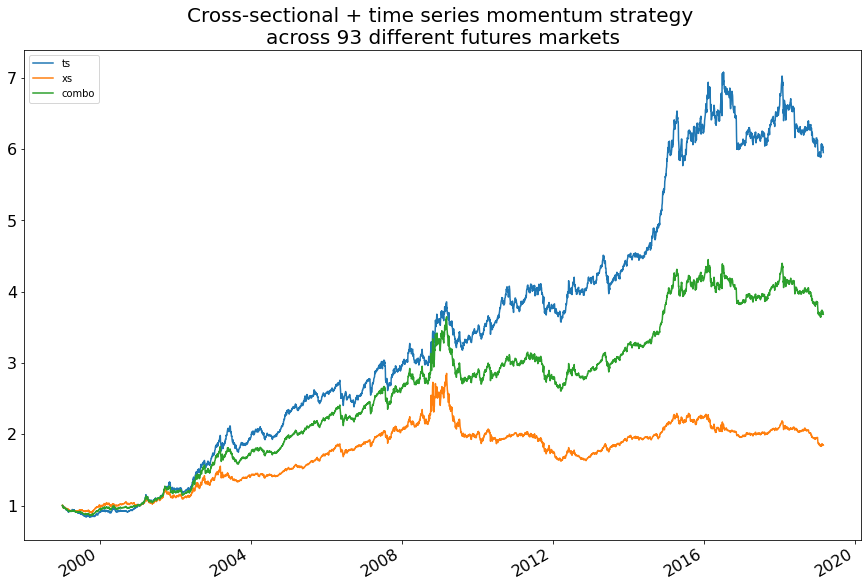

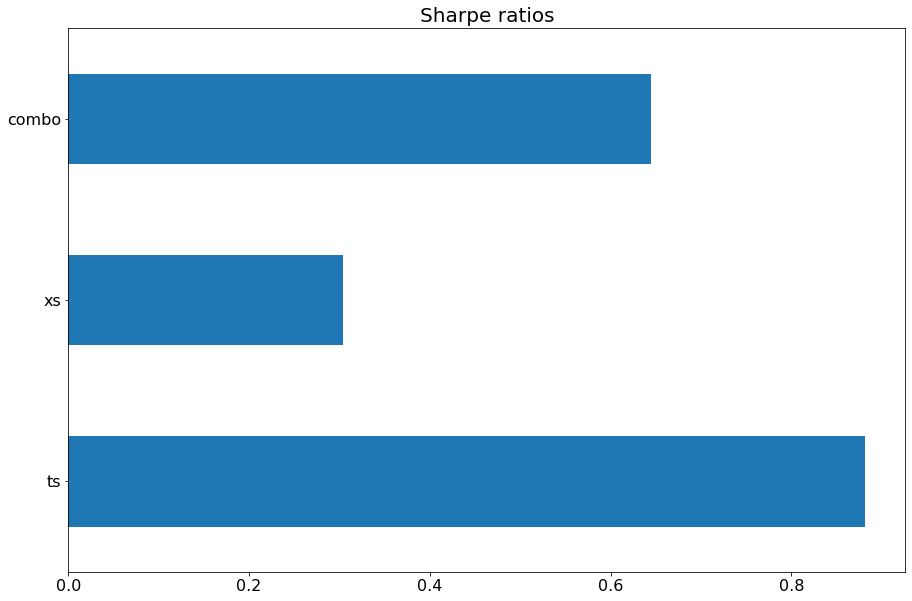

In [54]:
df2 = pd.concat([backtest.to_frame('ts'),
                 backtest2.to_frame('xs'),
                 backtest3.to_frame('combo')], axis=1, sort=True)
log_returns = np.log(df2).diff(1)
log_returns = (0.1/(log_returns.std() * np.sqrt(252))) * log_returns
df2 = np.exp(log_returns.fillna(0).cumsum())
df2.plot(figsize=(15,10), fontsize=16)
plt.title('Cross-sectional + time series momentum strategy \nacross 93 different futures markets', fontsize=20)
plt.show()
s = ((log_returns.mean() / log_returns.std()) * np.sqrt(252))
s.plot(figsize=(15,10), fontsize=16, kind='barh')
plt.title('Sharpe ratios', fontsize=20)
plt.show()

ts       0.881965
xs       0.303360
combo    0.644528
dtype: float64